In [67]:
import os
from typing import Any

from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets import CocoDetection
from torch.utils.data.dataloader import DataLoader

In [68]:
# path_data = "../coco/images/train2017"
# path_json_detection ="../coco/annotations/instances_train2017.json"
# dataset = CocoDetection(path_data, path_json_detection)

In [74]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, split : str = 'train', transform=None) -> None:
        super().__init__()
        self.files_path = f'../coco/images/{split}2017/'
        self.ann_file = f'../coco/annotations/instances_{split}2017.json'
        self.pixemaps_path = f'../coco/annotations/{split}2017/'

        self.inputs = os.listdir(self.files_path)
        self.targets = os.listdir(self.pixemaps_path)

        self.transform = transform# transforms.Compose([transforms.ToTensor()])

    def _load_image(self, path: str) -> Image.Image:
        return Image.open(path).convert("RGB")

    def __len__(self) -> int:
        return len(os.listdir(self.files_path))
    
    def __getitem__(self, index) -> Any:
        input_file_name = self.inputs[index]
        target_file_name = input_file_name[:-4] + '.png'

        image = self._load_image(self.files_path + self.inputs[index])
        target = self._load_image(self.pixemaps_path + target_file_name)

        if self.transform is not None:
            image = self.transform(image)
            target = self.transform(target)
            
        return image, target

In [75]:
dataset = CocoSegmentationDataset('train', transforms.Compose([transforms.ToTensor()]))
loader = DataLoader(dataset, batch_size=1)

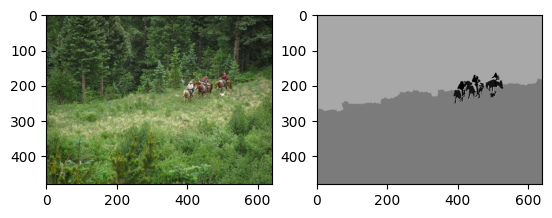

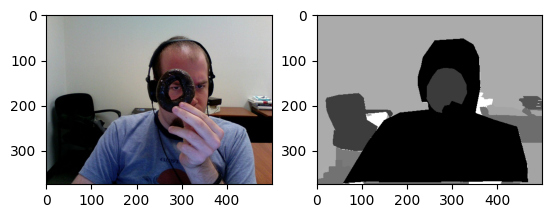

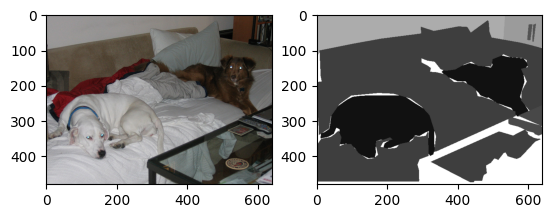

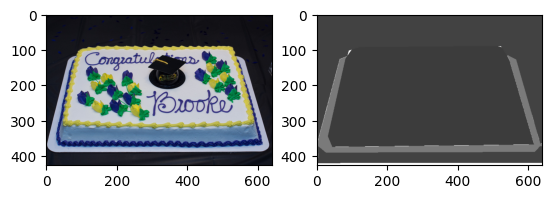

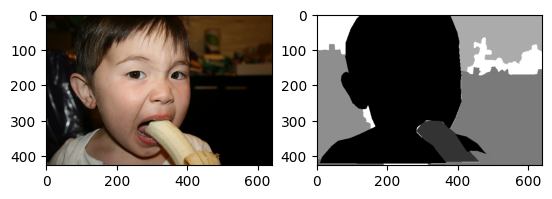

In [80]:
for x in range(len(dataset))[:5]:
    image, target = dataset[x]
    image = transforms.functional.to_pil_image(image)
    target = transforms.functional.to_pil_image(target)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(image)
    ax2.imshow(target)